# Welcome to this notebook on Simultaneous Perturbation Stochastic Approximation (SPSA) in 2 dimensions.

## What is SPSA?

SPSA is an algorithm developed by Spall (see: https://www.jhuapl.edu/spsa/). It can be used if noisy and unbiased measurements of the gradient $g(\boldsymbol{\theta}$) are available. It can also be used if only (noisy) measurements of the loss function $f(\boldsymbol{\theta})$ are available.

The advantage of SPSA compared to other algorithms is that only two loss measurements are required to generate an update. Therefore, SPSA is scalable.


## How does SPSA work?
Let $\eta_i \in (0, \infty)$ be a perturbation vector and $\Delta_i$ be a random vector such that $\{\Delta_i\}$ is an iid sequence with $\Delta_i(k)$ and $1/\Delta_i(k)$ bounded and symmetric around zero. The components $\Delta_i(k)$ are mutually independent. In practice, often the following binary random variable is used for $\Delta_i$:

$$
\mathbb{P}(\Delta_i(j) = -1) = \frac{1}{2} = \mathbb{P}(\Delta_i(j) = 1),
$$
for all $i$ and $j$.


The SPSA algorithm is then as follows:

___
**Start**: Choose starting value $\theta_0$, learning rate $\epsilon$ and take $i = 0$.
___
**Algorithm**:
1) Calculate ($g_i^{SPSA}(\theta_i))(j) = \frac{f(\theta_i+\eta_i\Delta_i)-f(\theta_i-\eta_i\Delta_i)}{2\eta_i\Delta_i(j)}$. 
2) Update $\theta_{i+1} = \theta_{i} - \epsilon (g_i^{SPSA}(\theta_i))$.
3) (a) stop if $i$ large or $|\theta_{i+1}-\theta_{i}|$ small enough.  
   (b) else: update $i$ to $i+1$ and go back to (1).
___

In the implementation below, you can perform SPSA on a two-dimensional function.

You can also experiment with what happens if stochastic noise is added to the objective function. This is interesting, as in (most) practical situations only noisy measurements of the objective function are available. You can also estimate the gradient multiple times and use the average gradient as the update.

You can also experiment with the difference between a fixed learning rate $\epsilon$ and a decreasing learning rate according to $\epsilon = \frac{1}{i+1}$.

## Try SPSA yourself and see what happens

In [19]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Fill in the objective function you would like to use:
def objective_f(theta1, theta2, STOCHASTIC, MU, SIGMA):
    
    function = np.power(theta1, 2) + np.power(theta2, 2)  #You can change this function.
    
    if STOCHASTIC:
        function = function + add_noise(MU, SIGMA)
    
    return function

In [21]:
# Adds normally distributed noise to the objective function. 
def add_noise(MU, SIGMA):
    return np.random.normal(MU, SIGMA, size=1)

In [22]:
# Fill in the number of iterations you would like to run SPSA.
NR_ITERATIONS = 100

In [23]:
# Do you want to use decreasing or fixed epsilon?
EPSILON_TYPE = 'fixed' #'fixed' or 'decreasing'
# In case of fixed epsilon, fill in the value for epsilon.
EPSILON_VALUE = 0.01

In [24]:
# Fill in the starting values for the optimisation:
THETA_0 = [8, 10] #As a list e.g., [10, 5].

In [25]:
# Do you want to do maximization or minimization?
OPTIMIZATION_TYPE = 'minimization' # 'minimization' or 'maximization' 

In [26]:
# Do you want to add stochasticity?
STOCHASTIC = False #False or True
MU = 0 # mu parameter of the normal distribution for the noise.
SIGMA = 1 # sigma parameter of the normal distribution for the noise.

# In case of stochasticity, do you want to estimate the gradient multiple times and use the average as update?
BATCH = False #False or True
NR_ESTIMATES = 10

In [27]:
def estimate_gradient(theta1, theta2, i, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES):
    
    delta_i = np.random.choice((-1, 1), size = 2)
    eta_i = 1/(i+1)
    
    if BATCH:
        gradient_estimates = np.zeros((NR_ESTIMATES, 2))
        for n in range(NR_ESTIMATES):
            perturbation_high = objective_f(theta1 + eta_i*delta_i[0], theta2 + eta_i*delta_i[1], STOCHASTIC, MU, SIGMA)
            perturbation_low = objective_f(theta1 - eta_i*delta_i[0], theta2 - eta_i*delta_i[1], STOCHASTIC, MU, SIGMA)
            numerator = perturbation_high-perturbation_low
            denominator = 2*eta_i*delta_i
            gradient_estimates[n] = np.divide(numerator, denominator)
        gradient_estimate = np.mean(gradient_estimates, axis=0)
    else:
        perturbation_high = objective_f(theta1 + eta_i*delta_i[0], theta2 + eta_i*delta_i[1], STOCHASTIC, MU, SIGMA)
        perturbation_low = objective_f(theta1 - eta_i*delta_i[0], theta2 - eta_i*delta_i[1], STOCHASTIC, MU, SIGMA)
        numerator = perturbation_high-perturbation_low
        denominator = 2*eta_i*delta_i
        gradient_estimate = np.divide(numerator, denominator)
    
    return gradient_estimate

In [28]:
# The SPSA algorithm
def SPSA(THETA_0, EPSILON_TYPE, EPSILON_VALUE, NR_ITERATIONS, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES):
    thetas = np.zeros((NR_ITERATIONS+1, 2))
    gradients = np.zeros((NR_ITERATIONS, 2))
    objective_values = np.zeros(NR_ITERATIONS)
    thetas[0] = THETA_0

    for i in range(NR_ITERATIONS):
        g = estimate_gradient(thetas[i][0], thetas[i][1], i, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES)
        gradients[i] = g
        if EPSILON_TYPE == 'fixed':
            if OPTIMIZATION_TYPE == 'minimization':
                thetas[i+1] = thetas[i] - EPSILON_VALUE * g
            if OPTIMIZATION_TYPE == 'maximization':
                thetas[i+1] = thetas[i] + EPSILON_VALUE * g
        if EPSILON_TYPE == 'decreasing':
            if OPTIMIZATION_TYPE == 'minimization':
                thetas[i+1] = thetas[i] - 1/(i+1) * g
            if OPTIMIZATION_TYPE == 'maximization':
                thetas[i+1] = thetas[i] + 1/(i+1) * g
        objective_values[i] = objective_f(thetas[i+1][0], thetas[i+1][1], STOCHASTIC, MU, SIGMA)
        
    return thetas, gradients, objective_values

In [29]:
# Plot the iterates and objective values during the optimisation
def plot_iterate_objective_gradient(thetas, gradients, objective_values, STOCHASTIC, MU, SIGMA):    
    fig, axs = plt.subplots(2,2, figsize=(20,20))

    # Plot the iterate
    axs[0,0].plot(thetas.T[0], color="darkblue", label = r'$\theta_1$')
    axs[0,0].plot(thetas.T[1], color="deepskyblue", label = r'$\theta_2$')
    axs[0,0].set_xlabel("Iteration")
    axs[0,0].set_ylabel(r"$\theta_n$")
    axs[0,0].set_title(r"$\theta_n$")
    axs[0,0].legend()
    
    # plot function
    r = 12
    x = np.linspace(-r, r, 100)
    y = np.linspace(-r, r, 100)
   
    X, Y = np.meshgrid(x, y)
    Z = np.array([[ objective_f( X[i,j], Y[i,j], False, 0, 1) for j in range(len(x))] for i in range(len(x))])
   
    CS = axs[0,1].contour(X, Y, Z)
    axs[0,1].clabel(CS, inline=1, fontsize=10)
   
    axs[0,1].plot(thetas.T[0], thetas.T[1], c="red", linewidth=1)
    axs[0,1].set_xlim(-r,r)
    axs[0,1].set_ylim(-r,r)
    axs[0,1].set_xlabel(r"$\theta_1$")
    axs[0,1].set_ylabel(r"$\theta_2$") 
    
    # Plot the objective values
    axs[1,0].plot(objective_values, color="darkblue")
    axs[1,0].set_xlabel("Iteration")
    axs[1,0].set_ylabel(r"f($\theta_n$)")
    axs[1,0].set_title(r"f($\theta_n$)")
    
    # Plot the estimated gradients
    axs[1,1].plot(gradients.T[0], color="darkblue", label = r'$g^{SPSA}_1$')
    axs[1,1].plot(gradients.T[1], color="deepskyblue", label = r'$g^{SPSA}_2$')
    axs[1,1].set_xlabel("Iteration")
    axs[1,1].set_ylabel(r"$g^{SPSA}$($\theta_n$)")
    axs[1,1].set_title(r"$g^{SPSA}$($\theta_n$)")
    axs[1,1].legend()

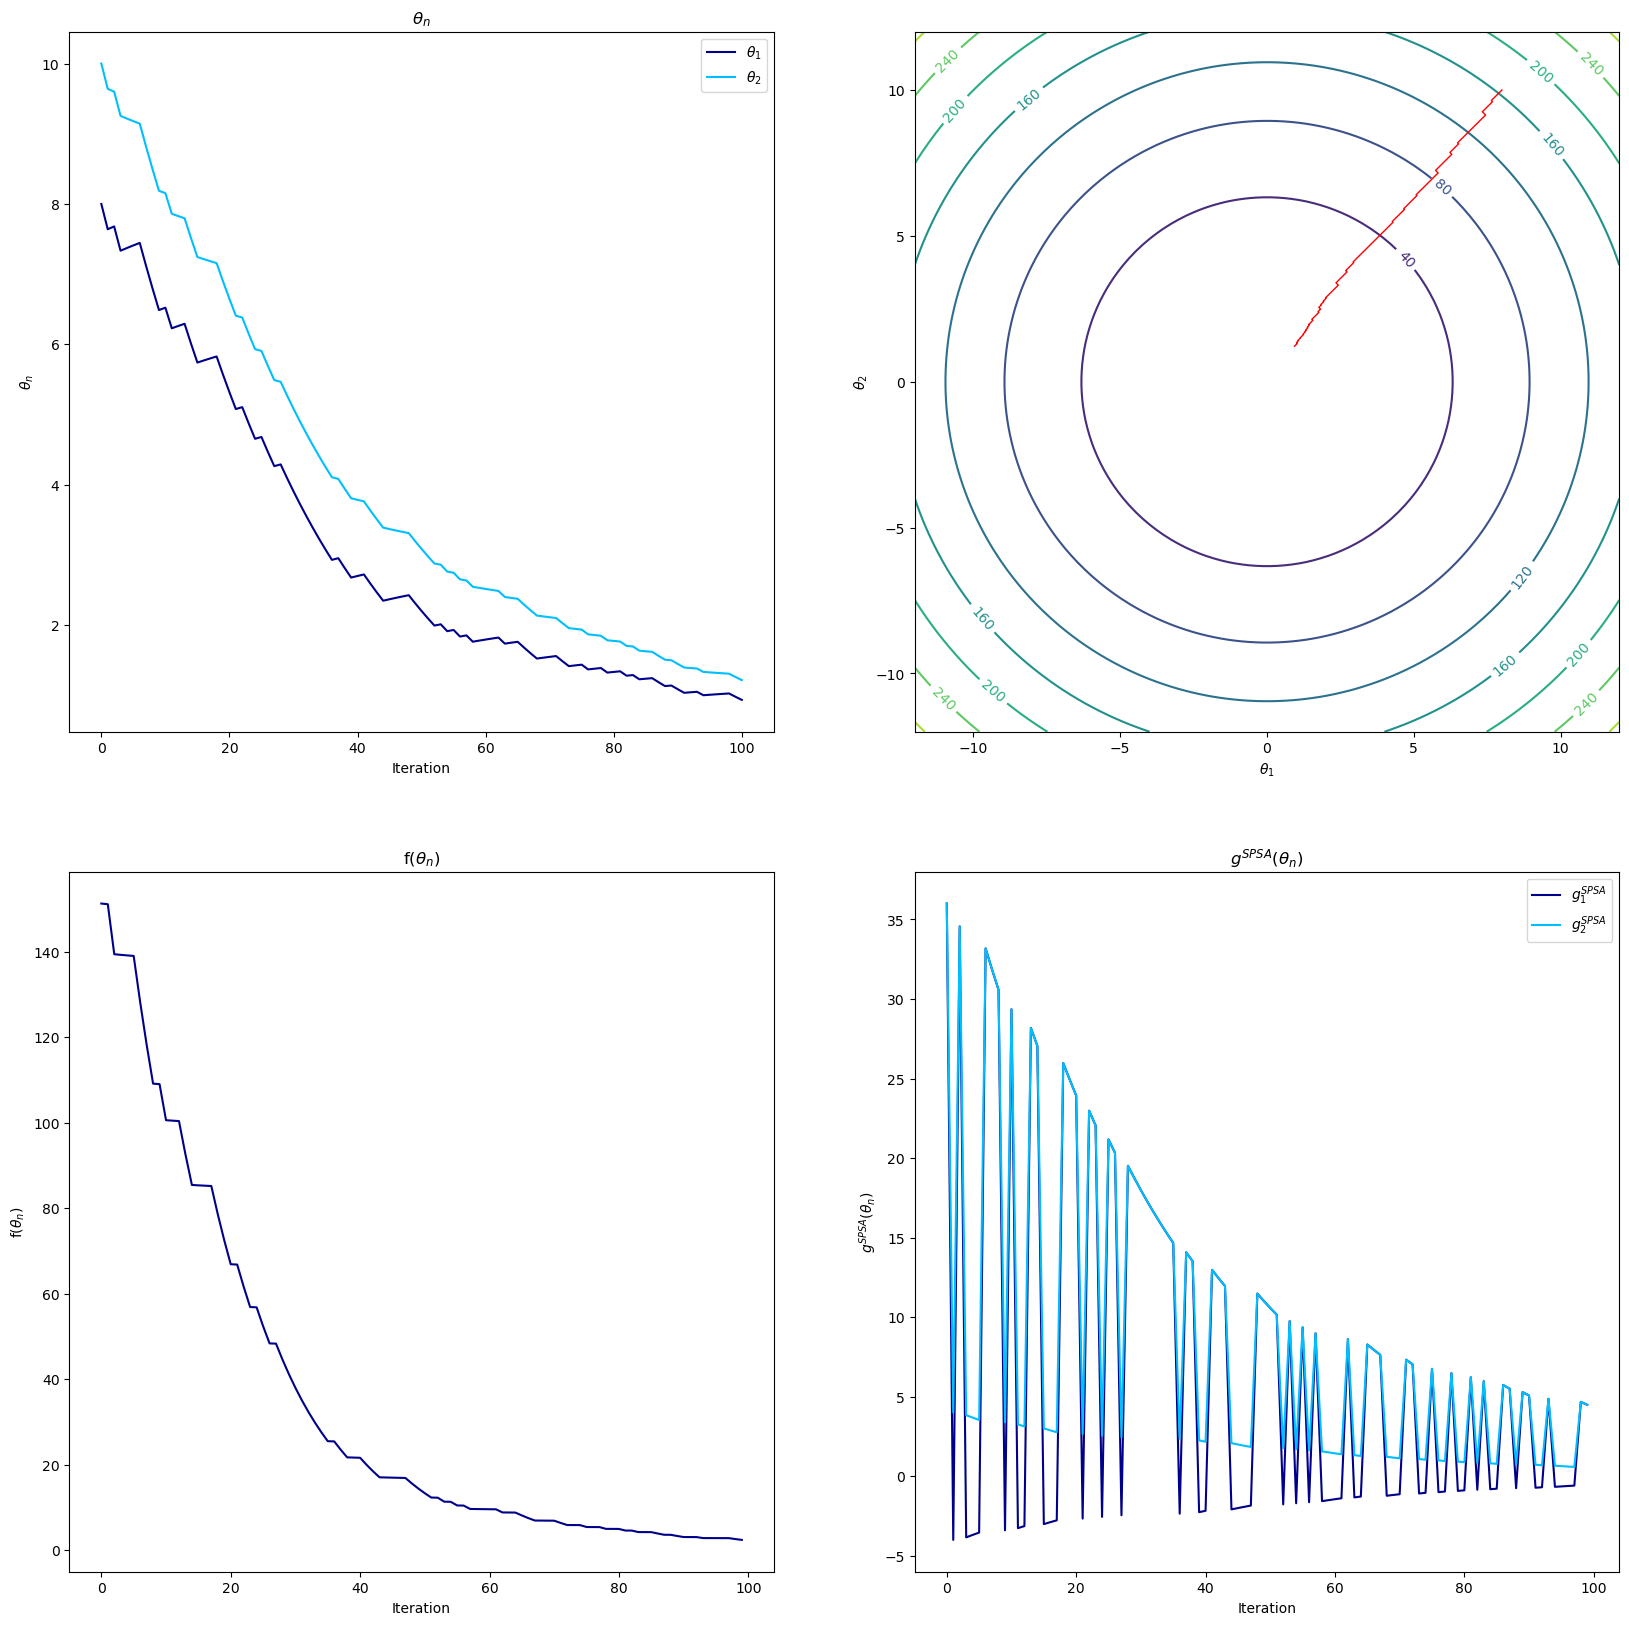

In [30]:
# Run SPSA and plot the optimisation
thetas, gradients, objective_values = SPSA(THETA_0, EPSILON_TYPE, EPSILON_VALUE, NR_ITERATIONS, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES)
plot_iterate_objective_gradient(thetas, gradients, objective_values, STOCHASTIC, MU, SIGMA)